In [2]:
#import torch.nn as nn
import numpy as np
import pandas as pd
from datetime import datetime
from glob import glob

import matplotlib.pyplot as plt 

from tp_utils.data_provider import read_prices, read_data
from tp_config import *
import pandas_ta as ta

In [3]:

def ts_to_datetime(ts):
#datetime.utcfromtimestamp(ts)
    return datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')

#Торговля одним контрактом
def simulation_01(prices, df_signals, init_data):
    market          = init_data['market']
    commission      = init_data['exchange_commission'] / 100
    start_capital   = init_data['start_capital']
    buy_correction  = init_data['buy_correction']
    sell_correction = init_data['sell_correction']
    contract        = init_data['contract']
     
    num_shares   = 0
    trade_profit = 0
    cum_profit   = 0    
    market_position = 0
    
    signals = np.zeros(df_signals.shape[0])
    ticks = prices['C'].values
    times = prices['T'].values
    start = len(ticks) - len(signals) 
    ticks = ticks[start:]
    times = times[start:]
    trade_statistics = []
    trades = 0

    for i in range(len(signals)) :
        ts = ts_to_datetime(times[i]/1000)
        trade_profit = 0
        if market_position == 0 and df_signals['Buy'].iloc[i]:
            signals[i] = 1
            price = ticks[i] * buy_correction
            num_shares    = num_shares + contract
            open_position = num_shares * price*(1+commission)
            market_position = 1
            
        elif market_position == 1 and df_signals['Sell'].iloc[i]:
            signals[i] = -1
            price = ticks[i] * sell_correction
            close_position = num_shares * price * (1-commission)
            trade_profit = close_position - open_position
            cum_profit  += trade_profit
            num_shares   = 0
            market_position = 0
            trades = trades + 1

        #if signals[i] !=0:
        trade_statistics.append([ts, ticks[i], signals[i], market_position, num_shares, trade_profit, cum_profit, trades])            
        

    df = pd.DataFrame(trade_statistics)
    df.columns = ['time', 'price', 'signal', 'MP', 'num_shares', 'profit', 'cum_profit', 'trades']
    df = df.astype({'signal':np.int32, 'MP':np.int32})
    df['high_val'] = df['cum_profit'].cummax()
    df['drawdown'] = df['cum_profit'] - df['high_val']
    return df

In [3]:
NonMPStrategy = pta.Strategy(
    name="",
    description="Non Multiprocessing Strategy by rename Columns",
    ta=[
        {"kind": "ema", "length": 8},
        {"kind": "ema", "length": 21},
        {"kind": "bbands", "length": 20, "col_names": ("BBL", "BBM", "BBU")},
        {"kind": "macd", "fast": 8, "slow": 21, "col_names": ("MACD", "MACD_H", "MACD_S")}
    ]
)
# Run it
#df.ta.strategy(NonMPStrategy)

In [179]:
MStrat = ta.Strategy(
    name="Momentum Custom",
    description="Non Multiprocessing Strategy by rename Columns",
    ta=[
        {"kind": "ao"},
        {"kind": "mom"},
#        {"kind": "squeeze"},
        {"kind": "stochrsi"}
    ]
)
# Run it
xx.ta.strategy(MStrat)

In [122]:
xx

,T,open,high,low,close,volume,AO_5_34,MOM_10,SQZ_20_2.0_20_1.5,SQZ_ON,SQZ_OFF,SQZ_NO,STOCHRSIk_14_14_3_3,STOCHRSId_14_14_3_3
0,1616619600000,0.00026617,0.00026774,0.00026407,0.00026529,24756.1,NaN,NaN,NaN,0,0,1,NaN,NaN
1,1616623200000,0.00026562,0.00026859,0.00026150,0.00026238,53796.4,NaN,NaN,NaN,0,0,1,NaN,NaN
2,1616626800000,0.00026280,0.00026312,0.00025885,0.00025993,44439.9,NaN,NaN,NaN,0,0,1,NaN,NaN
3,1616630400000,0.00025965,0.00025972,0.00025719,0.00025762,55187.7,NaN,NaN,NaN,0,0,1,NaN,NaN
4,1616634000000,0.00025763,0.00025948,0.00024883,0.00025129,58669.0,NaN,NaN,NaN,0,0,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1727,1622854800000,0.00105506,0.00108381,0.00104547,0.00107433,53009.0,0.000020537,0.00004073,0.000044027,0,1,0,82.011504528,73.349711243
1728,1622858400000,0.00107301,0.00112810,0.00107261,0.00111814,84683.9,0.000030048,0.00009206,0.000061498,0,1,0,100.000000000,85.065048149
1729,1622862000000,0.00111956,0.00113227,0.00109805,0.00110746,47501.9,0.000045093,0.00008037,0.000071007,0,1,0,94.795793365,92.269099298
1730,1622865600000,0.00110858,0.00112846,0.00110415,0.00110617,35204.2,0.000061758,0.00008287,0.000076025,0,1,0,88.388682037,94.394825134


In [127]:
xx = read_data('SOL-BTC', '1h', '2021-03-25')
xx.columns = (['T', 'open', 'high', 'low', 'close', 'volume'])
xx = xx.reset_index(drop=True)

In [180]:
inds_support = 12
res = []
for market in markets:
    xx = read_data(market, '4h', '2021-05-01')
    xx = xx[-100:]
    xx.columns = (['T', 'open', 'high', 'low', 'close', 'volume'])
    xx = xx.reset_index(drop=True)
    xx.ta.strategy(MStrat)
    inds = xx[xx.columns[6:]].tail(inds_support).mean()
    res.append(inds)

In [164]:
#xx = read_data(market, '4h', '2021-05-01')
#xx = xx[-100:]
df = pd.DataFrame(res).T
df.columns = markets

In [182]:
dfx = df.iloc[1].sort_values(ascending = False)
dfx = dfx[dfx>0]
dfx[:20]

KSM-BTC      0.001142917
SOL-BTC      0.000003984
DATA-BTC     0.000001716
TFUEL-BTC    0.000001404
CRV-BTC      0.000000067
XVG-BTC      0.000000013
PERL-BTC     0.000000012
VIDT-BTC     0.000000008
Name: MOM_10, dtype: float64

In [502]:
#xx.ta.strategy("Trend")

CustomTrends = pta.Strategy(
    name="Trends",
    description="Trends",
    ta=[
        {"kind": "amat"},#"fast":12, "slow":24},
        {"kind": "aroon"},
        {"kind": "chop"},
        {"kind": "cksp"},
    ]
)
# To run your "Custom Strategy"
xx.ta.strategy(CustomTrends)

In [12]:
pair = 'BTC'
index_assets = pd.read_csv('Portfolio/index_assets.csv')['asset'].tolist()
index_low_assets = pd.read_csv('Portfolio/index_low_assets.csv')['asset'].tolist()
full_assets = index_assets + index_low_assets

assets = index_assets + index_low_assets
markets = [m + '-' + pair for m in assets]

In [9]:
from Portfolio.portfolio_tools import load_data_for_portfolio

In [39]:
df_all =  load_data_for_portfolio(markets, '6h')   
print(datetime.fromtimestamp(df_all.index[0]/1000))
print(datetime.fromtimestamp(df_all.index[-1]/1000))

AAVE-BTC
ADA-BTC
ALGO-BTC
AVAX-BTC
BNB-BTC
BCH-BTC
CAKE-BTC
CTSI-BTC
DOGE-BTC
DOT-BTC
EOS-BTC
ETC-BTC
ETH-BTC
FTT-BTC
LINK-BTC
LTC-BTC
LUNA-BTC
MATIC-BTC
NEO-BTC
RUNE-BTC
SOL-BTC
SXP-BTC
TFUEL-BTC
THETA-BTC
TRX-BTC
UNI-BTC
VET-BTC
WBTC-BTC
XMR-BTC
XRP-BTC
ZIL-BTC
ALGO-BTC
1INCH-BTC
BAT-BTC
BNT-BTC
BAL-BTC
CRV-BTC
DATA-BTC
DASH-BTC
DGB-BTC
EGLD-BTC
FIL-BTC
FIRO-BTC
FTM-BTC
GVT-BTC
IOST-BTC
IOTX-BTC
IRIS-BTC
IOTA-BTC
LTC-BTC
LSK-BTC
KAVA-BTC
KNC-BTC
KSM-BTC
MANA-BTC
MKR-BTC
NANO-BTC
OMG-BTC
PERL-BTC
QTUM-BTC
UTK-BTC
VIDT-BTC
SAND-BTC
STPT-BTC
STRAX-BTC
SRM-BTC
SYS-BTC
WAN-BTC
XLM-BTC
XVG-BTC
XVS-BTC
XTZ-BTC
ZEN-BTC
2021-03-08 10:00:00
2021-04-10 16:00:00


In [90]:
xx = read_data('SOL-BTC', '12h', '2021-03-25')
xx.columns = (['T', 'open', 'high', 'low', 'close', 'volume'])
xx[['open', 'high', 'low', 'close']] = xx[['open', 'high', 'low', 'close']] *10000 
xx = xx.reset_index(drop=True)

xx.ta.strategy("Momentum")

38it [00:01, 26.98it/s]


In [91]:
cols = xx.tail().dropna(axis = 1).columns
xx = xx[50:]

In [92]:
xx.columns

Index(['T', 'open', 'high', 'low', 'close', 'volume', 'AO_5_34', 'APO_12_26',
       'BIAS_SMA_26', 'BOP', 'AR_26', 'BR_26', 'CCI_14_0.015', 'CFO_9',
       'CG_10', 'CMO_14', 'COPC_11_14_10', 'CTI_12', 'ER_10', 'BULLP_13',
       'BEARP_13', 'FISHERT_9_1', 'FISHERTs_9_1', 'INERTIA_20_14', 'K_9_3',
       'D_9_3', 'J_9_3', 'KST_10_15_20_30_10_10_10_15', 'KSTs_9',
       'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'MOM_10', 'PGO_14',
       'PPO_12_26_9', 'PPOh_12_26_9', 'PPOs_12_26_9', 'PSL_12', 'PVO_12_26_9',
       'PVOh_12_26_9', 'PVOs_12_26_9', 'QQE_14_5_4.236',
       'QQE_14_5_4.236_RSIMA', 'QQEl_14_5_4.236', 'QQEs_14_5_4.236', 'ROC_10',
       'RSI_14', 'RSX_14', 'RVGI_14_4', 'RVGIs_14_4', 'SLOPE_1', 'SMI_5_20_5',
       'SMIs_5_20_5', 'SMIo_5_20_5', 'SQZ_20_2.0_20_1.5', 'SQZ_ON', 'SQZ_OFF',
       'SQZ_NO', 'STC_10_12_26_0.5', 'STCmacd_10_12_26_0.5',
       'STCstoch_10_12_26_0.5', 'STOCHk_14_3_3', 'STOCHd_14_3_3',
       'STOCHRSIk_14_14_3_3', 'STOCHRSId_14_14_3_3', 'TRI

<AxesSubplot:>

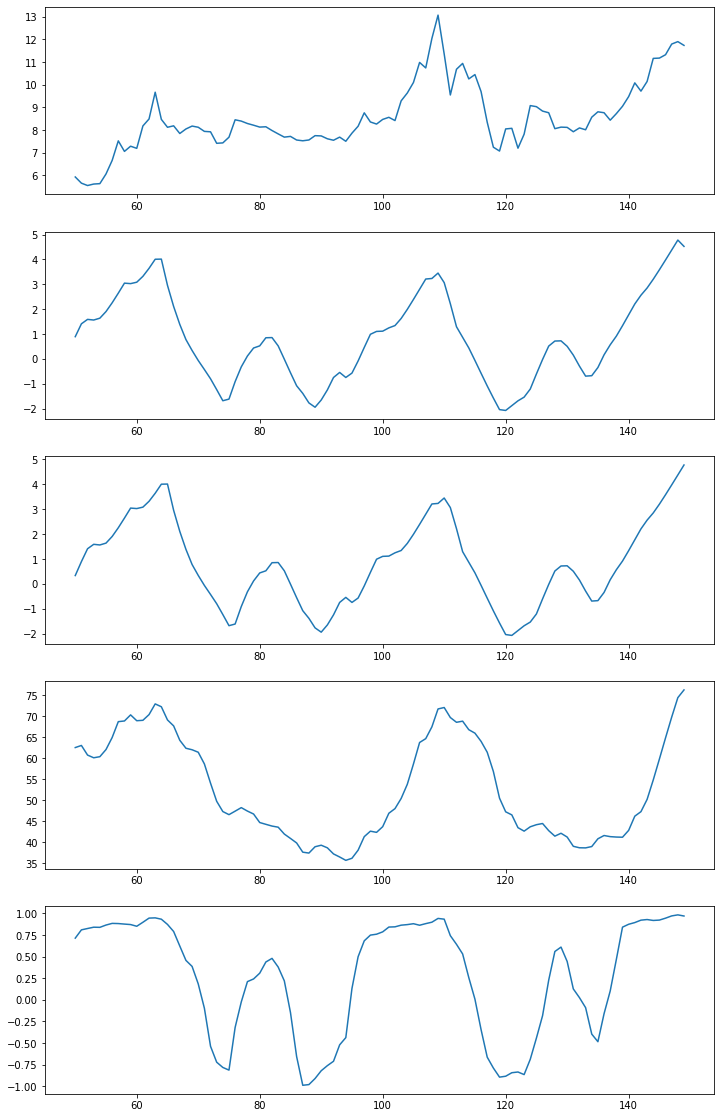

In [99]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize = (12,20))
xx['close'].plot(ax=axes[0])
xx['FISHERT_9_1'].plot(ax=axes[1])
xx['FISHERTs_9_1'].plot(ax=axes[2])
xx['INERTIA_20_14'].plot(ax=axes[3])
xx['CTI_12'].plot(ax=axes[4])

<AxesSubplot:>

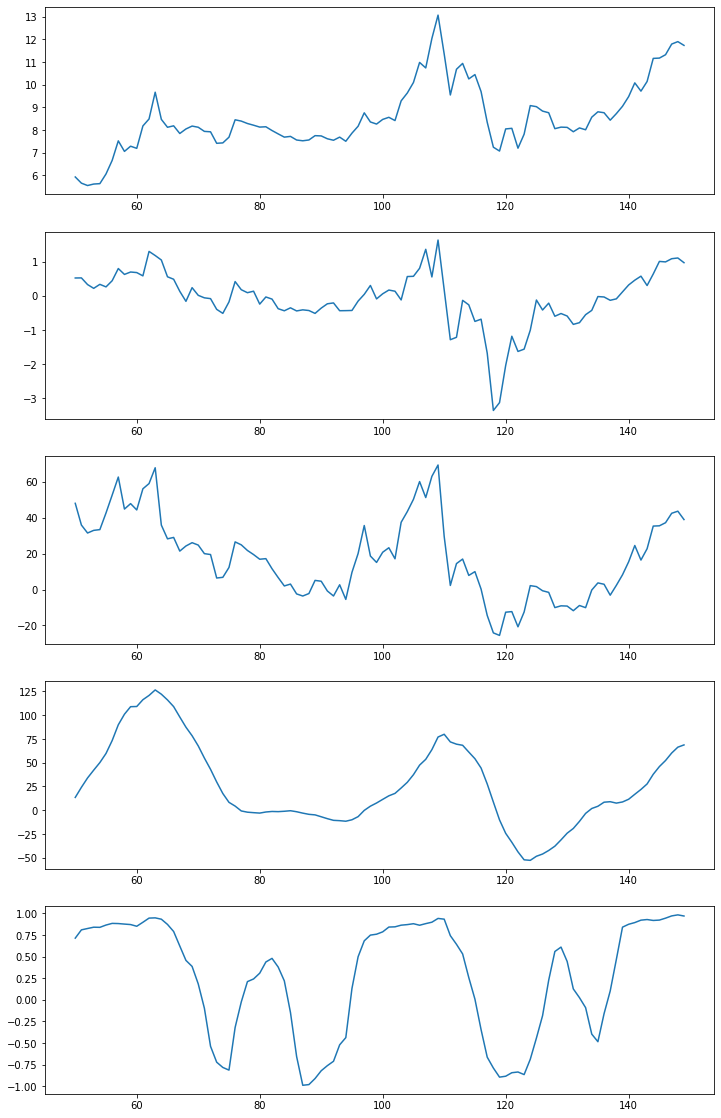

In [96]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize = (12,20))
xx['close'].plot(ax=axes[0])
xx['BEARP_13'].plot(ax=axes[1])
xx['CMO_14'].plot(ax=axes[2])
xx['COPC_11_14_10'].plot(ax=axes[3])
xx['CTI_12'].plot(ax=axes[4])

<AxesSubplot:>

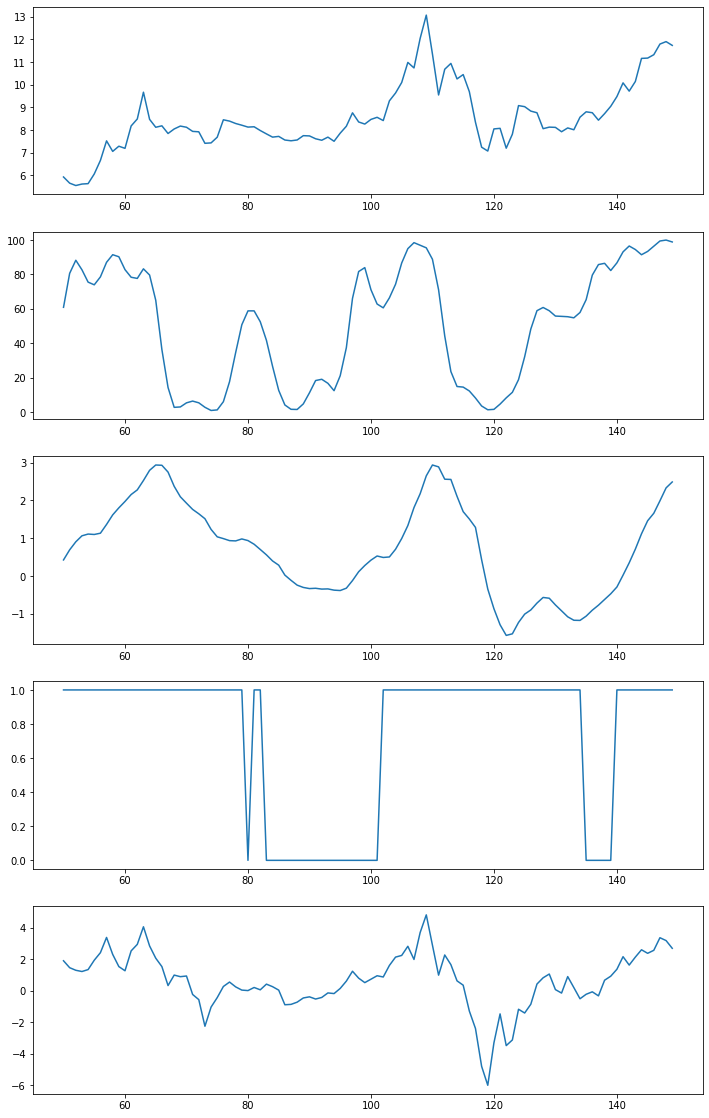

In [88]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize = (12,20))
xx['close'].plot(ax=axes[0])
xx['STOCHRSId_14_14_3_3'].plot(ax=axes[1])
xx['AO_5_34'].plot(ax=axes[2])
xx['SQZ_OFF'].plot(ax=axes[3])
xx['MOM_10'].plot(ax=axes[4])

<AxesSubplot:>

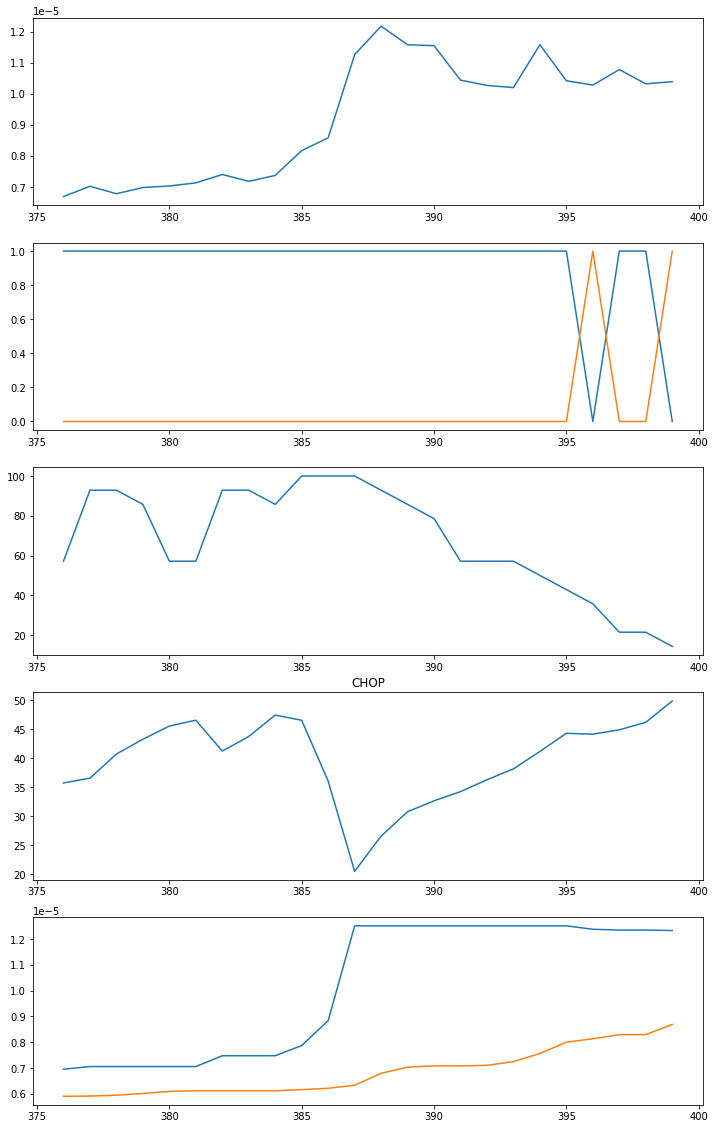

In [484]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize = (12,20))
data['close'].plot(ax=axes[0])
data['AMATe_LR_2'].plot(ax=axes[1])
data['AMATe_SR_2'].plot(ax=axes[1])
data['AROONOSC_14'].plot(ax=axes[2])
data['CHOP_14_1_100'].plot(ax=axes[3], title = 'CHOP')
data['CKSPl_10_1_9'].plot(ax=axes[4])
data['CKSPs_10_1_9'].plot(ax=axes[4])

In [462]:
data['AMATe_LR_2'].sum()

10

## Trend rank

In [490]:
import os
markets_path = glob(DATA_PATH_CRYPTO + '/BTC/*')
markets = [os.path.basename(m) for m in markets_path]

In [422]:
pair = 'BTC'
assets = [ 'ADA', 'ATOM', 'BNB', 'EOS','ETH','FTT', 'LINK',  'REN','THETA', 'TRX', 'ENJ', 'LUNA', 'VET', 'ONE', 'WRX']
markets = [s + '-' + pair for s in assets]

In [ ]:
res = []
for market in markets:
    print(market)
    df = read_data(market, '1h', '2021-03-25')
    df.columns = (['T', 'open', 'high', 'low', 'close', 'volume'])
    df = df.reset_index(drop=True)
    if df.shape[0] == 0:
        continue
    df['vol_btc'] = df.volume * df.close
    df.ta.strategy(CustomTrends)
    data = df[-24:]
    res.append([market, data['AMATe_LR_2'].sum(), data.vol_btc.sum()])

1.7737600000000002

In [507]:
df_res = pd.DataFrame(res, columns = ['market', 'score', 'volume'])
df_res = df_res[df_res.score > 12]
df_res.sort_values('score', ascending = False)

,market,score,volume
16,ARDR-BTC,22,1997.460103430
60,CTXC-BTC,22,303.580340390
78,ELF-BTC,22,468.450645260
38,BNB-BTC,20,9657.692093977
7,AION-BTC,20,274.784665840
5,AERGO-BTC,20,298.693660510
18,ARPA-BTC,19,107.658617700
20,AST-BTC,19,83.566407610
172,POWR-BTC,18,251.633109120
98,GLM-BTC,18,165.313135170


In [500]:
data

,T,open,high,low,close,volume,AMATe_LR_2,AMATe_SR_2,AROOND_14,AROONU_14,AROONOSC_14,CHOP_14_1_100,CKSPl_10_1_9,CKSPs_10_1_9
377,1617976800000,0.99847,0.99867,0.99648,0.99648,0.02382,1,0,64.285714286,71.428571429,7.142857143,95.174519688,0.996506882,0.998643118
378,1617980400000,0.99850,0.99851,0.99648,0.99850,0.01234,1,0,57.142857143,64.285714286,7.142857143,94.902694145,0.996519674,0.998643118
379,1617984000000,0.99850,0.99867,0.99648,0.99800,0.08539,1,0,50.000000000,57.142857143,7.142857143,94.861751604,0.996519674,0.998643118
380,1617987600000,0.99800,0.99868,0.99700,0.99868,0.11313,1,0,42.857142857,100.000000000,57.142857143,94.311581239,0.996565036,0.998643118
381,1617991200000,0.99867,0.99867,0.99650,0.99651,0.09991,0,1,35.714285714,92.857142857,57.142857143,97.179034463,0.996565036,0.998643118
382,1617994800000,0.99651,0.99866,0.99649,0.99652,0.16349,0,1,28.571428571,85.714285714,57.142857143,97.332860053,0.996565036,0.998643118
383,1617998400000,0.99702,0.99851,0.99651,0.99652,0.01660,0,1,21.428571429,78.571428571,57.142857143,97.268841929,0.996566311,0.998643118
384,1618002000000,0.99850,0.99850,0.99652,0.99749,0.00168,0,1,14.285714286,71.428571429,57.142857143,96.934192923,0.996579680,0.998643118
385,1618005600000,0.99849,0.99865,0.99647,0.99647,0.15151,0,1,7.142857143,64.285714286,57.142857143,96.869497127,0.996579680,0.998644806
386,1618009200000,0.99648,0.99648,0.99647,0.99647,0.00325,0,1,0.000000000,57.142857143,57.142857143,94.046931457,0.996781541,0.998378459


In [315]:
CustomStrategy = pta.Strategy(
    name="Momo and Volatility",
    description="SMA 50,200, BBANDS, RSI, MACD and Volume SMA 20",
    ta=[
#        {"kind": "bbands", "length": 20},
        {"kind": "rsi", "length":12},
        {"kind": "adx", "length":12},
    ]
)
# To run your "Custom Strategy"
xx.ta.strategy(CustomStrategy)

### Trade Signals

In [273]:
xx['Buy'] = (xx.ADX_12 > 30) & (xx.RSI_12> 60) & (xx.ADX_12.diff() >0)
xx['Sell'] = xx.ADX_12.diff() < 0
signals = xx[['Buy', 'Sell']]

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(xx[100:150])

In [274]:
init_data = {'exchange_commission': 0.075, #percent
             'start_capital'     : 100,
             'buy_correction'    : 1.0001,
             'sell_correction'   : 0.9999,
             'contract'          : 1000,  
             'robot_name'        : '',
             'market'            : '',
             'kline'             : ''  
            }

In [275]:
prices = read_data('TRX-BTC', '1h', '2021-01-01')
res = simulation_01(prices, signals, init_data)

In [276]:
res

,time,price,signal,MP,num_shares,profit,cum_profit,trades,high_val,drawdown
0,2021-01-01 01:00:00,0.00000092,0,0,0,0.0,0.000000000,0,0.0,0.000000000
1,2021-01-01 02:00:00,0.00000092,0,0,0,0.0,0.000000000,0,0.0,0.000000000
2,2021-01-01 03:00:00,0.00000092,0,0,0,0.0,0.000000000,0,0.0,0.000000000
3,2021-01-01 04:00:00,0.00000093,0,0,0,0.0,0.000000000,0,0.0,0.000000000
4,2021-01-01 05:00:00,0.00000093,0,0,0,0.0,0.000000000,0,0.0,0.000000000
...,...,...,...,...,...,...,...,...,...,...
2197,2021-04-02 16:00:00,0.00000148,0,0,0,0.0,-0.000246662,45,0.0,-0.000246662
2198,2021-04-02 17:00:00,0.00000147,0,0,0,0.0,-0.000246662,45,0.0,-0.000246662
2199,2021-04-02 18:00:00,0.00000148,0,0,0,0.0,-0.000246662,45,0.0,-0.000246662
2200,2021-04-02 19:00:00,0.00000148,0,0,0,0.0,-0.000246662,45,0.0,-0.000246662


In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(res)

### Plot

In [282]:
data = xx[1900:2140]
data = xx[2140:]

<AxesSubplot:>

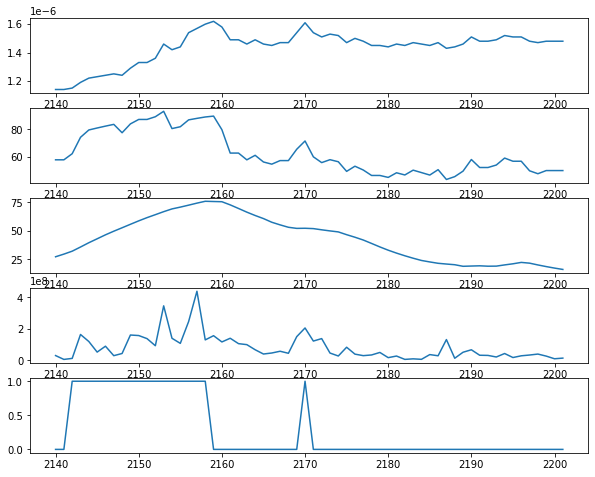

In [283]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize = (10,8))
data['close'].plot(ax=axes[0])
data['RSI_12'].plot(ax=axes[1])
data['ADX_12'].plot(ax=axes[2])
data['volume'].plot(ax=axes[3])
data['Buy'].astype(int).plot(ax=axes[4])

In [287]:
help(pta.amat)

Help on function amat in module pandas_ta.trend.amat:

amat(close=None, fast=None, slow=None, mamode=None, lookback=None, slope_length=None, offset=None, **kwargs)
    Indicator: Archer Moving Averages Trends (AMAT)



In [260]:
res[2020:2060]

,time,price,signal,MP,num_shares,profit,cum_profit,trades,high_val,drawdown
2020,2021-03-26 07:00:00,0.00000110,0,0,0,0.000000000,-0.000655782,40,0.0,-0.000655782
2021,2021-03-26 08:00:00,0.00000110,0,0,0,0.000000000,-0.000655782,40,0.0,-0.000655782
2022,2021-03-26 09:00:00,0.00000111,0,0,0,0.000000000,-0.000655782,40,0.0,-0.000655782
2023,2021-03-26 10:00:00,0.00000110,1,1,1000,0.000000000,-0.000655782,40,0.0,-0.000655782
2024,2021-03-26 11:00:00,0.00000109,0,1,1000,0.000000000,-0.000655782,40,0.0,-0.000655782
2025,2021-03-26 12:00:00,0.00000110,-1,0,0,-0.000001870,-0.000657652,41,0.0,-0.000657652
2026,2021-03-26 13:00:00,0.00000111,1,1,1000,0.000000000,-0.000657652,41,0.0,-0.000657652
2027,2021-03-26 14:00:00,0.00000115,0,1,1000,0.000000000,-0.000657652,41,0.0,-0.000657652
2028,2021-03-26 15:00:00,0.00000126,0,1,1000,0.000000000,-0.000657652,41,0.0,-0.000657652
2029,2021-03-26 16:00:00,0.00000119,0,1,1000,0.000000000,-0.000657652,41,0.0,-0.000657652


In [17]:
rsi_14 = ta.momentum.RSIIndicator(df['C'], 14)
rsi_14.rsi()

0                NaN
1                NaN
2                NaN
3                NaN
4                NaN
            ...     
2197    50.987508960
2198    49.220638268
2199    51.047479129
2200    51.047479129
2201    51.047479129
Name: rsi, Length: 2202, dtype: float64

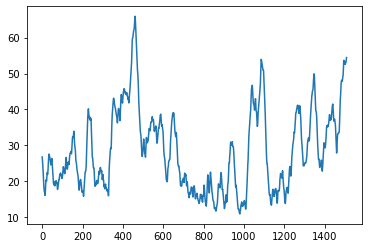

In [39]:
import talib
df = read_data('THETA-BTC', '12h')
res = talib.ADXR(df['H'].values, df['L'].values, df['C'].values, 14) 
plt.plot(res[40:])

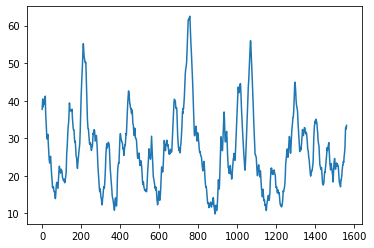

In [41]:
df = read_data('VET-BTC', '12h')
res = talib.ADXR(df['H'].values, df['L'].values, df['C'].values, 14) 
plt.plot(res[40:])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021D4DF6B828>]],
      dtype=object)

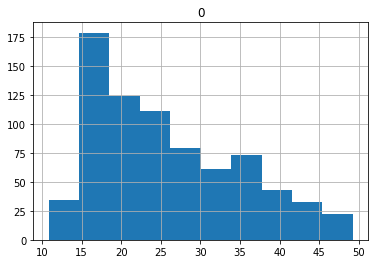

In [34]:
pd.DataFrame(res[40:]).hist()

## 30-100 trades on parameter

In [2]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: #51719C' if v else '' for v in is_max]

In [14]:
df = pd.read_csv('dd_USDT.csv')
#df = pd.read_csv('dd_USDT.csv')


df['min_trades'] = df['trades'] - df['params'].apply(lambda x: len(x.split(','))) * 30
df['pdd'] = -df['profit']/df['dd'] 
#df['opt_trades'] = df['trades'] - df['params'].apply(lambda x: len(x.split(','))) * 100

df = df[df['min_trades'] > 0]
df = df[df['profit'] > 0]
df = df[df['pdd'] > 2]

df['c1'] = -df['profit']/df['dd'] * np.log(df['trades'])
#df = df[df['asset'] == 'LTC-USDT']

In [15]:
df

,asset,tf,robot,params,profit,dd,trades,min_trades,pdd,c1


In [11]:
pvt = pd.pivot_table(df, values=['c1'], index=['robot'],  columns=['tf'])
pvt.style.apply(highlight_max)

In [12]:
pvt = pd.pivot_table(df, values=['profit'], index=['robot'],  columns=['tf'])
pvt.style.apply(highlight_max)

In [13]:
pd.pivot_table(df, values=['dd'], index=['robot'],  columns=['tf'])

dd          
tf                                15m        5m
robot                                          
kestner-ma                        NaN -0.000002
ma-2-crossover          -1.439044e-06 -0.000002
ma-2-crossover-ichimoku -2.206098e-06 -0.000002
rsi                     -9.226891e-07 -0.000002

In [ ]:
pvt = pd.pivot_table(df, values=['trades'], index=['robot'],  columns=['tf'])
pvt.style.apply(highlight_max)

In [ ]:
df.sort_values('tf')

In [ ]:
df = df[df['robot'] == 'ma-rsi']
pd.pivot_table(df, values=['profit'], index=['tf'],  columns=['asset'])

In [ ]:
pd.pivot_table(df, values=['trades'], index=['tf'],  columns=['asset'])

In [ ]:
df['c1'] = df['profit'] * np.sqrt(df['trades'])
pd.pivot_table(df, values=['dd'], index=['tf'],  columns=['robot'])


In [ ]:
data_path = 'G:\Code\Projects\QuantMod\Logs\Logs'
files = glob(data_path + '/*')

In [ ]:
import os
fn_full = files[12]
fn = os.path.basename(fn_full)
print(fn)
pd.read_csv(fn_full)

In [2]:
import numpy as np
X = np.random.rand(3,3)

In [12]:
W1 = 2 *np.random.random((3,3)) - 1
W2 = 2 *np.random.random((3,1)) - 1
b1 = 0.1
b2 = 0.1 
z1 = X@W1 + b1
z2 = z1@W2 + b2

In [13]:
z1

array([[-0.10681998, -0.25498285, -0.01188085],
       [ 0.11184781,  0.10890602, -0.21377916],
       [ 0.24222738, -0.15552755, -0.22852381]])

In [12]:

def render(self, env, **kwargs):
    history = pd.DataFrame(trade_history)

    actions = list(history.action)
    p = list(history.price)

    buy = {}
    sell = {}

    for i in range(len(actions) - 1):
        a1 = actions[i]
        a2 = actions[i + 1]

        if a1 != a2:
            if a1 == 0 and a2 == 1:
                buy[i] = p[i]
            else:
                sell[i] = p[i]

    buy = pd.Series(buy)
    sell = pd.Series(sell)

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    fig.suptitle("Performance")

    axs[0].plot(np.arange(len(p)), p, label="price", color=self.color)
    axs[0].scatter(buy.index, buy.values, marker="^", color="green")
    axs[0].scatter(sell.index, sell.values, marker="^", color="red")
    axs[0].set_title("Trading Chart")
    axs[0].set_xlabel("Step")
    axs[0].set_ylabel("Price (USD/TTC)")

    performance = env.action_scheme.portfolio.performance
    performance = pd.DataFrame(performance).transpose()

    performance.net_worth.plot(ax=axs[1])
    axs[1].set_title("Net Worth")
    axs[1].set_xlabel("Step")
    axs[1].set_ylabel("Amount (USD)")

    plt.show()